## 利用贝叶斯公式，说明为什么 P(y|w1, w2) ≠ P(y|w1)P(y|w2) （即使做了独立假设）

    假设 w1 与 w2 独立，此时：
    左 = P(w1,w2,y) / P(w1,w2) = P(w1|y) x P(w2|y) x P(y) / (P(w1) x P(w2))
    右 = P(w1,y) / P(w1) x P(w2,y) / P(w2) = 左 x P(y)

## Naive Bayes

In [24]:
from collections import Counter
from math import log
import jieba

# (neg, pos) 的分类标记取为 (0, 1)，与各列表索引对应
train_files = ['./neg_train.txt', './pos_train.txt']
test_files = ['./neg_test.txt', './pos_test.txt']

def read_lines(file):
    with open(file, 'r') as f:
        lines = f.readlines()
    return [line.strip().decode('utf-8') for line in lines]

In [26]:
nums = [len(read_lines(train_files[c])) for c in (0, 1)]
prior = [nums[c]/float(sum(nums)) for c in (0, 1)]  # 先验概率 neg, pos
prior

[0.5288782233791589, 0.47112177662084115]

计算条件概率，用数据平滑

In [27]:
def get_count_and_vocab(files=train_files):
    """读取训练数据，得到不同类别下的计数及词表"""
    count = [Counter(), Counter()]  # 计数：neg, pos
    vocab = set()  # 词表
    # pos 1; neg 0
    # set 会自动记录不重复的词
    for c in (0, 1):
        for line in read_lines(files[c]):
            for word in jieba.cut(line):
                count[c][word] += 1
                vocab.add(word)
    return count, vocab

def to_log_prob(count, vocab):
    """将计数转换为条件概率，采用 Laplace add1 平滑"""
    log_conditional = [Counter(), Counter()]  # neg, pos
    vsize = len(vocab)
    for c in (0, 1):
        total = sum(count[c].values())
        for word in vocab:  # 这里必须是 vocab 而不是 count[c].keys()
            log_conditional[c][word] = log(count[c][word] + 1) - log(total + vsize)
    return log_conditional

count, vocab = get_count_and_vocab()
log_conditional = to_log_prob(count, vocab)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.449 seconds.
Prefix dict has been built succesfully.


按行读取并判断，测试集中的词如果没有出现在训练集，则忽略

In [28]:
def cal_joint_prob(docu, c):
    """计算文本 docu 与分类 c 的联合概率(取对数)"""
    log_joint_prob = log(prior[c])
    words = jieba.cut(docu)
    for word in words:
        if word in vocab:  # 参考 slp ch6.2, 仅考虑（训练集）词表内的词
            log_joint_prob += log_conditional[c][word]
    return log_joint_prob

def classify(docu):
    """对文本 docu 进行分类"""
    prob = [cal_joint_prob(docu, c) for c in (0, 1)]
    return 1 if prob[1] > prob[0] else 0

results = [[], []]  # 分类结果 neg, pos
for c in (0, 1):
    for line in read_lines(test_files[c]):
        results[c].append(classify(line))

In [54]:
total = len(results[0]) + len(results[1])
neg_test_counter, pos_test_counter = Counter(results[0]), Counter(results[1])
true_pos = pos_test_counter[1]
false_pos = neg_test_counter[1]
true_neg = neg_test_counter[0]
false_neg = pos_test_counter[0]

# 混淆矩阵
confusion_matrix = ('\n'.join(['{:^15}' * 3] * 3)).format(
    'n='+str(total), 'predicted:neg', 'predicted:pos',
    'actual:neg', true_neg, false_pos,
    'actual:pos', false_neg, true_pos)
print(confusion_matrix)

# 评价指标：precision, recall, f_measure
precision = float(true_pos) / (true_pos + false_pos)
recall = float(true_pos) / (true_pos + false_neg)
f_measure = 2 * precision * recall / float(precision + recall)
print(('\nprecision = {:.3f}, recall = {:.3f}, f_measure = {:.3f}').format(
    precision, recall, f_measure))

    n=10538     predicted:neg  predicted:pos 
  actual:neg        4850            723      
  actual:pos        1094           3871      

precision = 0.843, recall = 0.780, f_measure = 0.810


## 梯度下降

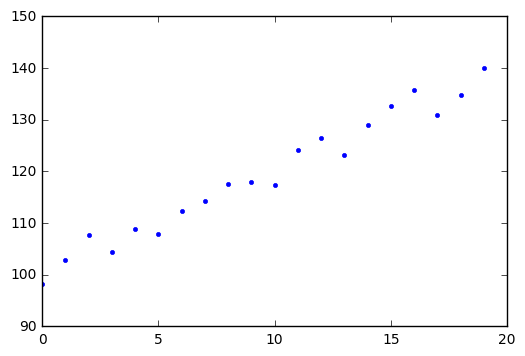

In [4]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

# 生成数据
size = 20
x = np.arange(size)
y = 100.0 + 2.0 * x + np.random.normal(scale=2, size=size)
plt.plot(x, y, '.');

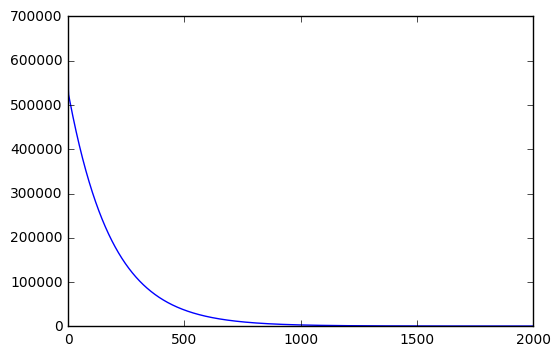

In [5]:
def to_matrix(x):
    """对每条数据补充 x0 = 1，返回 x 矩阵及数据个数"""
    m = x.shape[0]
    x_mat = np.array([np.ones(m), x]).T
    return x_mat, m

def compute_cost(x, y, theta):
    xx, m = to_matrix(x)
    return 0.5 * m * ((xx.dot(theta) - y)**2).sum()

def gradient_descent(x, y, theta, alpha, iternum):
    """实施梯度下降法
    theta: 参数向量
    alpha: learning rate
    iternum: 迭代次数
    """
    cost_history = []
    xx, m = to_matrix(x)
    for i in range(iternum):
        gradient = xx.T.dot(xx.dot(theta) - y)
        theta = theta - alpha / m * gradient
        cost_history.append(compute_cost(x, y, theta))
    return theta, cost_history


# 用 theta 表示参数向量，这里 theta = [b, w], yi = theta.dot(xi)
theta = np.array([0., 0.])  # 参数初始化
theta, cost_history = gradient_descent(x, y, theta, 0.01, 2000)

# cost 随迭代次数变化的曲线
plt.plot(cost_history);

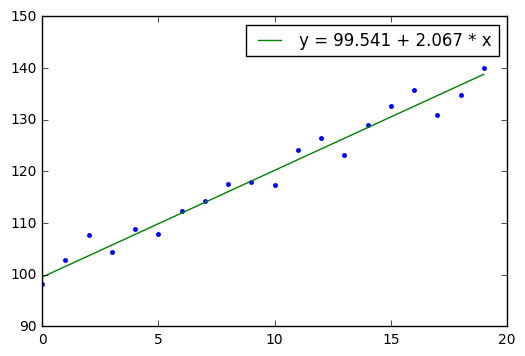

In [8]:
label = 'y = {:.3f} + {:.3f} * x'.format(*theta)
plt.plot(x, y, '.')
plt.plot(x, theta[0] + theta[1] * x, label=label)
plt.legend();

In [10]:
# normal equation 直接求解
from numpy.linalg import pinv
X = to_matrix(x)[0]
theta2 = pinv(X.T.dot(X)).dot(X.T).dot(y)
theta2

array([ 100.00719114,    2.03087821])